# PerturbationX
PerturbationX is a package for analyzing causal networks in combination with gene expression data. It is based on the [TopoNPA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4227138/) algorithm. It was developed as part of a Master's thesis at the University of Ljubljana, Faculty of Computer and Information Science and in collaboration with the National Institute of Biology. This notebook demonstrates the use of PerturbationX for analyzing a small causal network.

## Installation
The package can be installed from PyPI or directly from GitHub. It requires a Python version of 3.10 or newer. It is based on NetworkX and pandas and requires Cytoscape for visualization. The latter can be downloaded from [here](https://cytoscape.org/download.html).

```bash
python -m pip install perturbationx # PyPI
python -m pip install git+https://github.com/mikethenut/perturbationx # GitHub
```

## Network import
For demonstration purposes, a small example network with accompanying datasets is included in the package. The network core is based on the human Osmotic Stress network from the [Causal Biological Networks database](https://www.causalbionet.com/), available under Network ID osmotic_stress_2.0_hs. All non-causal edges were removed and the largest connected component was then selected. The network boundary and datasets were generated synthetically and do not correspond to any real biological system.

In [ ]:
import perturbationx as px
from perturbationx import CausalNetwork



In [2]:
my_cbn = CausalNetwork.from_tsv("data/NPANetworks/Hs_CFA_Apoptosis_backbone.tsv", edge_type="core")
my_cbn.add_edges_from_tsv("data/NPANetworks/Hs_CFA_Apoptosis_downstream.tsv", edge_type="boundary")

In [3]:
datasets = dict()
datasets["CS (5m)"] = pd.read_table("./data/COPD1/CS (5m).tsv")

In [ ]:
datasets["CS (2m) + Sham (3m)"] = pd.read_table("./data/COPD1/CS (2m) + Sham (3m).tsv")
datasets["CS (2m) + Sham (5m)"] = pd.read_table("./data/COPD1/CS (2m) + Sham (5m).tsv")
datasets["CS (4m) + Sham (1m)"] = pd.read_table("./data/COPD1/CS (4m) + Sham (1m).tsv")
datasets["CS (4m) + Sham (3m)"] = pd.read_table("./data/COPD1/CS (4m) + Sham (3m).tsv")
datasets["CS (7m)"] = pd.read_table("./data/COPD1/CS (7m).tsv")

In [4]:
for data_id, dataset in datasets.items():
    datasets[data_id] = dataset.rename(columns={"nodeLabel": "nodeID", "foldChange": "logFC"})

In [5]:
results = my_cbn.toponpa(datasets)

2023-09-16 16:36:34,346 INFO -- PREPROCESSING NETWORK
2023-09-16 16:36:34,457 INFO -- core edges: 230
2023-09-16 16:36:34,458 INFO -- boundary edges: 11114
2023-09-16 16:36:34,459 INFO -- core nodes: 133
2023-09-16 16:36:34,460 INFO -- outer boundary nodes: 5729
2023-09-16 16:36:34,461 INFO -- core nodes with boundary edges (inner boundary): 67
2023-09-16 16:36:36,290 INFO -- COMPUTING NPA FOR DATASET 'CS (5m)'
2023-09-16 16:36:36,321 INFO -- boundary nodes matched with dataset: 5225
2023-09-16 16:36:36,322 INFO -- boundary edges remaining: 10356
2023-09-16 16:36:36,323 INFO -- core nodes with boundary edges remaining: 67


In [6]:
display(results.global_info())

,NPA,variance,ci_lower,ci_upper,k2_value,o_value
CS (5m),0.113495,0.000019,0.10496,0.12203,0.0,0.0


In [7]:
display(results.node_info("CS (5m)"))

attr,contribution,coefficient,variance,ci_lower,ci_upper,p_value
act(p(MGI:Ptgs2)),0.002432,-0.178167,0.000014,-0.185495,-0.170839,0.000000
"complex(p(MGI:Ripk1),p(MGI:Tnfrsf10b))",0.001288,0.074858,0.000055,0.060350,0.089366,0.000000
p(MGI:Fasl),0.008080,0.229628,0.000038,0.217510,0.241746,0.000000
act(p(MGI:Creb1)),0.000012,-0.004828,0.000022,-0.014086,0.004430,0.153358
act(p(MGI:Tlr4)),0.000873,0.086215,0.000007,0.080902,0.091527,0.000000
...,...,...,...,...,...,...
p(MGI:Bbc3),0.006605,0.169520,0.000014,0.162155,0.176886,0.000000
act(p(MGI:Tnf)),0.007320,0.176276,0.000027,0.166091,0.186461,0.000000
act(p(MGI:Birc5)),0.002142,-0.082673,0.000015,-0.090315,-0.075031,0.000000
p(MGI:Bcl2a1b),0.000936,-0.078163,0.000017,-0.086205,-0.070120,0.000000


In [9]:
results.node_attributes()

['contribution', 'coefficient', 'variance', 'ci_lower', 'ci_upper', 'p_value']

In [9]:
display(results.node_info("contribution"))

data,CS (5m),CS (7m)
act(p(MGI:Tnfrsf10b)),0.002914,0.002986
act(p(MGI:Tlr4)),0.000903,0.000535
p(MGI:Fasl),0.008193,0.009685
"act(complex(GOCC:""mitochondrial permeability transition pore complex""))",0.016611,0.016322
"act(p(SFAM:""PRKA Family""))",0.000260,0.000288
...,...,...
act(p(MGI:Map3k7)),0.000924,0.000038
p(MGI:Stat3),0.000281,0.000285
p(MGI:Tnfrsf1a),0.005713,0.005919
"a(SCHEM:""Phosphatidylinositol-3,4,5-trisphosphate"")",0.000021,0.000008


In [13]:
for d in results.datasets():
    values = results.node_info("contribution")[d].to_dict()
    print(values)

{'act(complex(SCOMP:"Nfkb Complex"))': 0.0001804754731128689, 'p(MGI:Fasl)': 0.005295661438978998, 'act(p(SFAM:"AKT Family"))': 0.014030256976249258, 'act(p(MGI:Dffa))': 0.0013725281423219004, 'act(p(MGI:Rela))': 0.0024159309765942965, 'act(p(MGI:Bad))': 0.013318028713701822, 'p(MGI:Tlr4)': 0.0024252998948527376, 'act(p(MGI:Ep300))': 0.00043637802135504936, 'p(MGI:Tnfrsf10b)': 0.002280446855350541, 'p(MGI:Bcl2a1b)': 0.0002843352633071266, 'act(p(MGI:Akt2))': 0.00836791765371085, 'act(p(MGI:Fas))': 0.02147137820178909, 'act(p(MGI:Mapk10))': 6.13673352070862e-05, 'act(complex(GOCC:"mitochondrial permeability transition pore complex"))': 0.018653931647016276, 'act(p(MGI:Tradd))': 0.026074218713919028, 'p(MGI:Bcl2l1)': 0.002663886873447179, 'a(SCHEM:Calcium)': 0.0008541738699375782, 'act(p(MGI:Pdpk1))': 0.00010700020939351912, 'p(MGI:Cflar)': 0.0011507699751299345, 'act(p(MGI:Mapk1))': 0.00022518654083958776, 'act(p(MGI:Bmx))': 0.0036778775142161557, 'act(p(MGI:Nkx3-1))': 0.108084605695902

In [9]:
results.distributions()

['k2', 'o']

<Figure size 640x480 with 0 Axes>

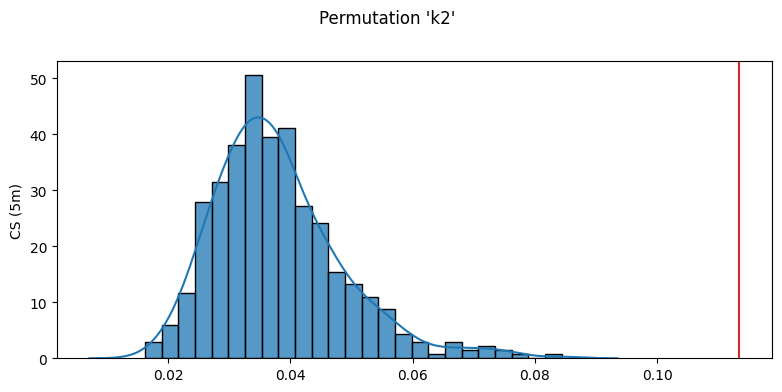

[<Axes: ylabel='CS (5m)'>]

In [10]:
results.plot_distribution('k2')

In [8]:
import py4cytoscape as p4c
p4c.cytoscape_version_info()

2023-09-16 15:49:15,949 DEBUG -- Calling cytoscape_version_info()
2023-09-16 15:49:15,951 DEBUG -- ǀCalling cyrest_get('version', base_url='http://127.0.0.1:1234/v1')
2023-09-16 15:49:15,953 DEBUG -- ǀHTTP GET(http://127.0.0.1:1234/v1/version)
2023-09-16 15:49:15,962 DEBUG -- ǀOK[200], content: {"apiVersion":"v1","cytoscapeVersion":"3.10.1"}
2023-09-16 15:49:15,964 DEBUG -- ǀReturning 'cyrest_get': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.1'}
2023-09-16 15:49:15,966 DEBUG -- Returning 'cytoscape_version_info': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.1', 'automationAPIVersion': '1.6.0', 'py4cytoscapeVersion': '1.6.0'}
2023-09-16 15:49:15,967 DEBUG -- --------------------


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.6.0'}

In [29]:
display = results.display_network(display_boundary=False)

Applying default style...
Applying preferred layout


In [30]:
display.highlight_leading_nodes("CS (5m)", cutoff=0.3)

58492

In [31]:
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_neighbors=2, neighborhood_type="intersection")

58492

In [28]:
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_neighbors=1, neighborhood_type="union")

56460

In [22]:
import logging
logging.disable(logging.DEBUG)
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_shortest_paths="directed")

52364

In [25]:
import logging
logging.disable(logging.DEBUG)
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_shortest_paths="all", path_length_tolerance=1)

54428

In [9]:
display.color_nodes("CS (5m)", "contribution")

8168

In [5]:
results.export("results.json")